### Temporal overlapbetween gamma and beta rythms

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import xarray as xr
import xrscipy as xrs
from frites.conn.conn_spec import conn_spec
from frites.conn.conn_tf import _tf_decomp
from frites.utils import parallel_func
from mne.time_frequency import psd_array_multitaper
from scipy.signal import find_peaks
from tqdm import tqdm

from config import get_dates
from GDa.session import session
from GDa.signal.surrogates import trial_swap_surrogates
from GDa.util import _extract_roi, create_stages_time_grid

In [3]:
sessions = get_dates("lucy")

In [4]:
def flatten(xss):
    return [x for xs in xss for x in xs]

#### Setting spectral analysis parameters

In [5]:
# Defining parameters
decim = 10  # Downsampling factor
mode = "multitaper"  # Wheter to use Morlet or Multitaper
n_freqs = 30  # How many frequencies to use
fc = np.linspace(4, 80, n_freqs)  # Frequency array
n_cycles = fc / 4  # Number of cycles
mt_bandwidth = 4

bands = {
    "theta": [0, 6],
    "alpha": [6, 14],
    "beta_1": [14, 26],
    "beta_2": [26, 43],
    "gamma": [43, 80],
}

#### Loanding data

In [33]:
def load_session_data(sid):

    # Instantiate class
    ses = session(
        raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
        monkey="lucy",
        date=sid,
        session=1,
        slvr_msmod=False,
        align_to="cue",
        evt_dt=[-.8, 1.5],
    )

    # Read data from .mat files
    ses.read_from_mat()

    # Filtering by trials
    data = ses.data 
    data.values = data * 1e6
    data = ses.filter_trials(trial_type=[1], behavioral_response=[1])
    # ROIs with channels
    rois = [
        f"{roi} ({channel})"
        for roi, channel in zip(data.roi.data, data.channels_labels)
    ]
    data = data.assign_coords({"roi": rois})

    return data

In [34]:
sid = "141024"

data = [load_session_data(sid) for sid in [sid]][0]

In [62]:
sfreq = data.fsample


power_static, freqs = psd_array_multitaper(
    data, sfreq, fmin=0, fmax=80, bandwidth=1, n_jobs=20
)

    Using multitaper spectrum estimation with 1 DPSS windows


In [63]:
power_static = xr.DataArray(
    power_static,
    dims=("trials", "roi", "freqs"),
    coords=(data.trials, data.roi, freqs),
    name="power",
)

In [64]:
power_static = power_static.mean("trials")
power_static = power_static / power_static.max("freqs")

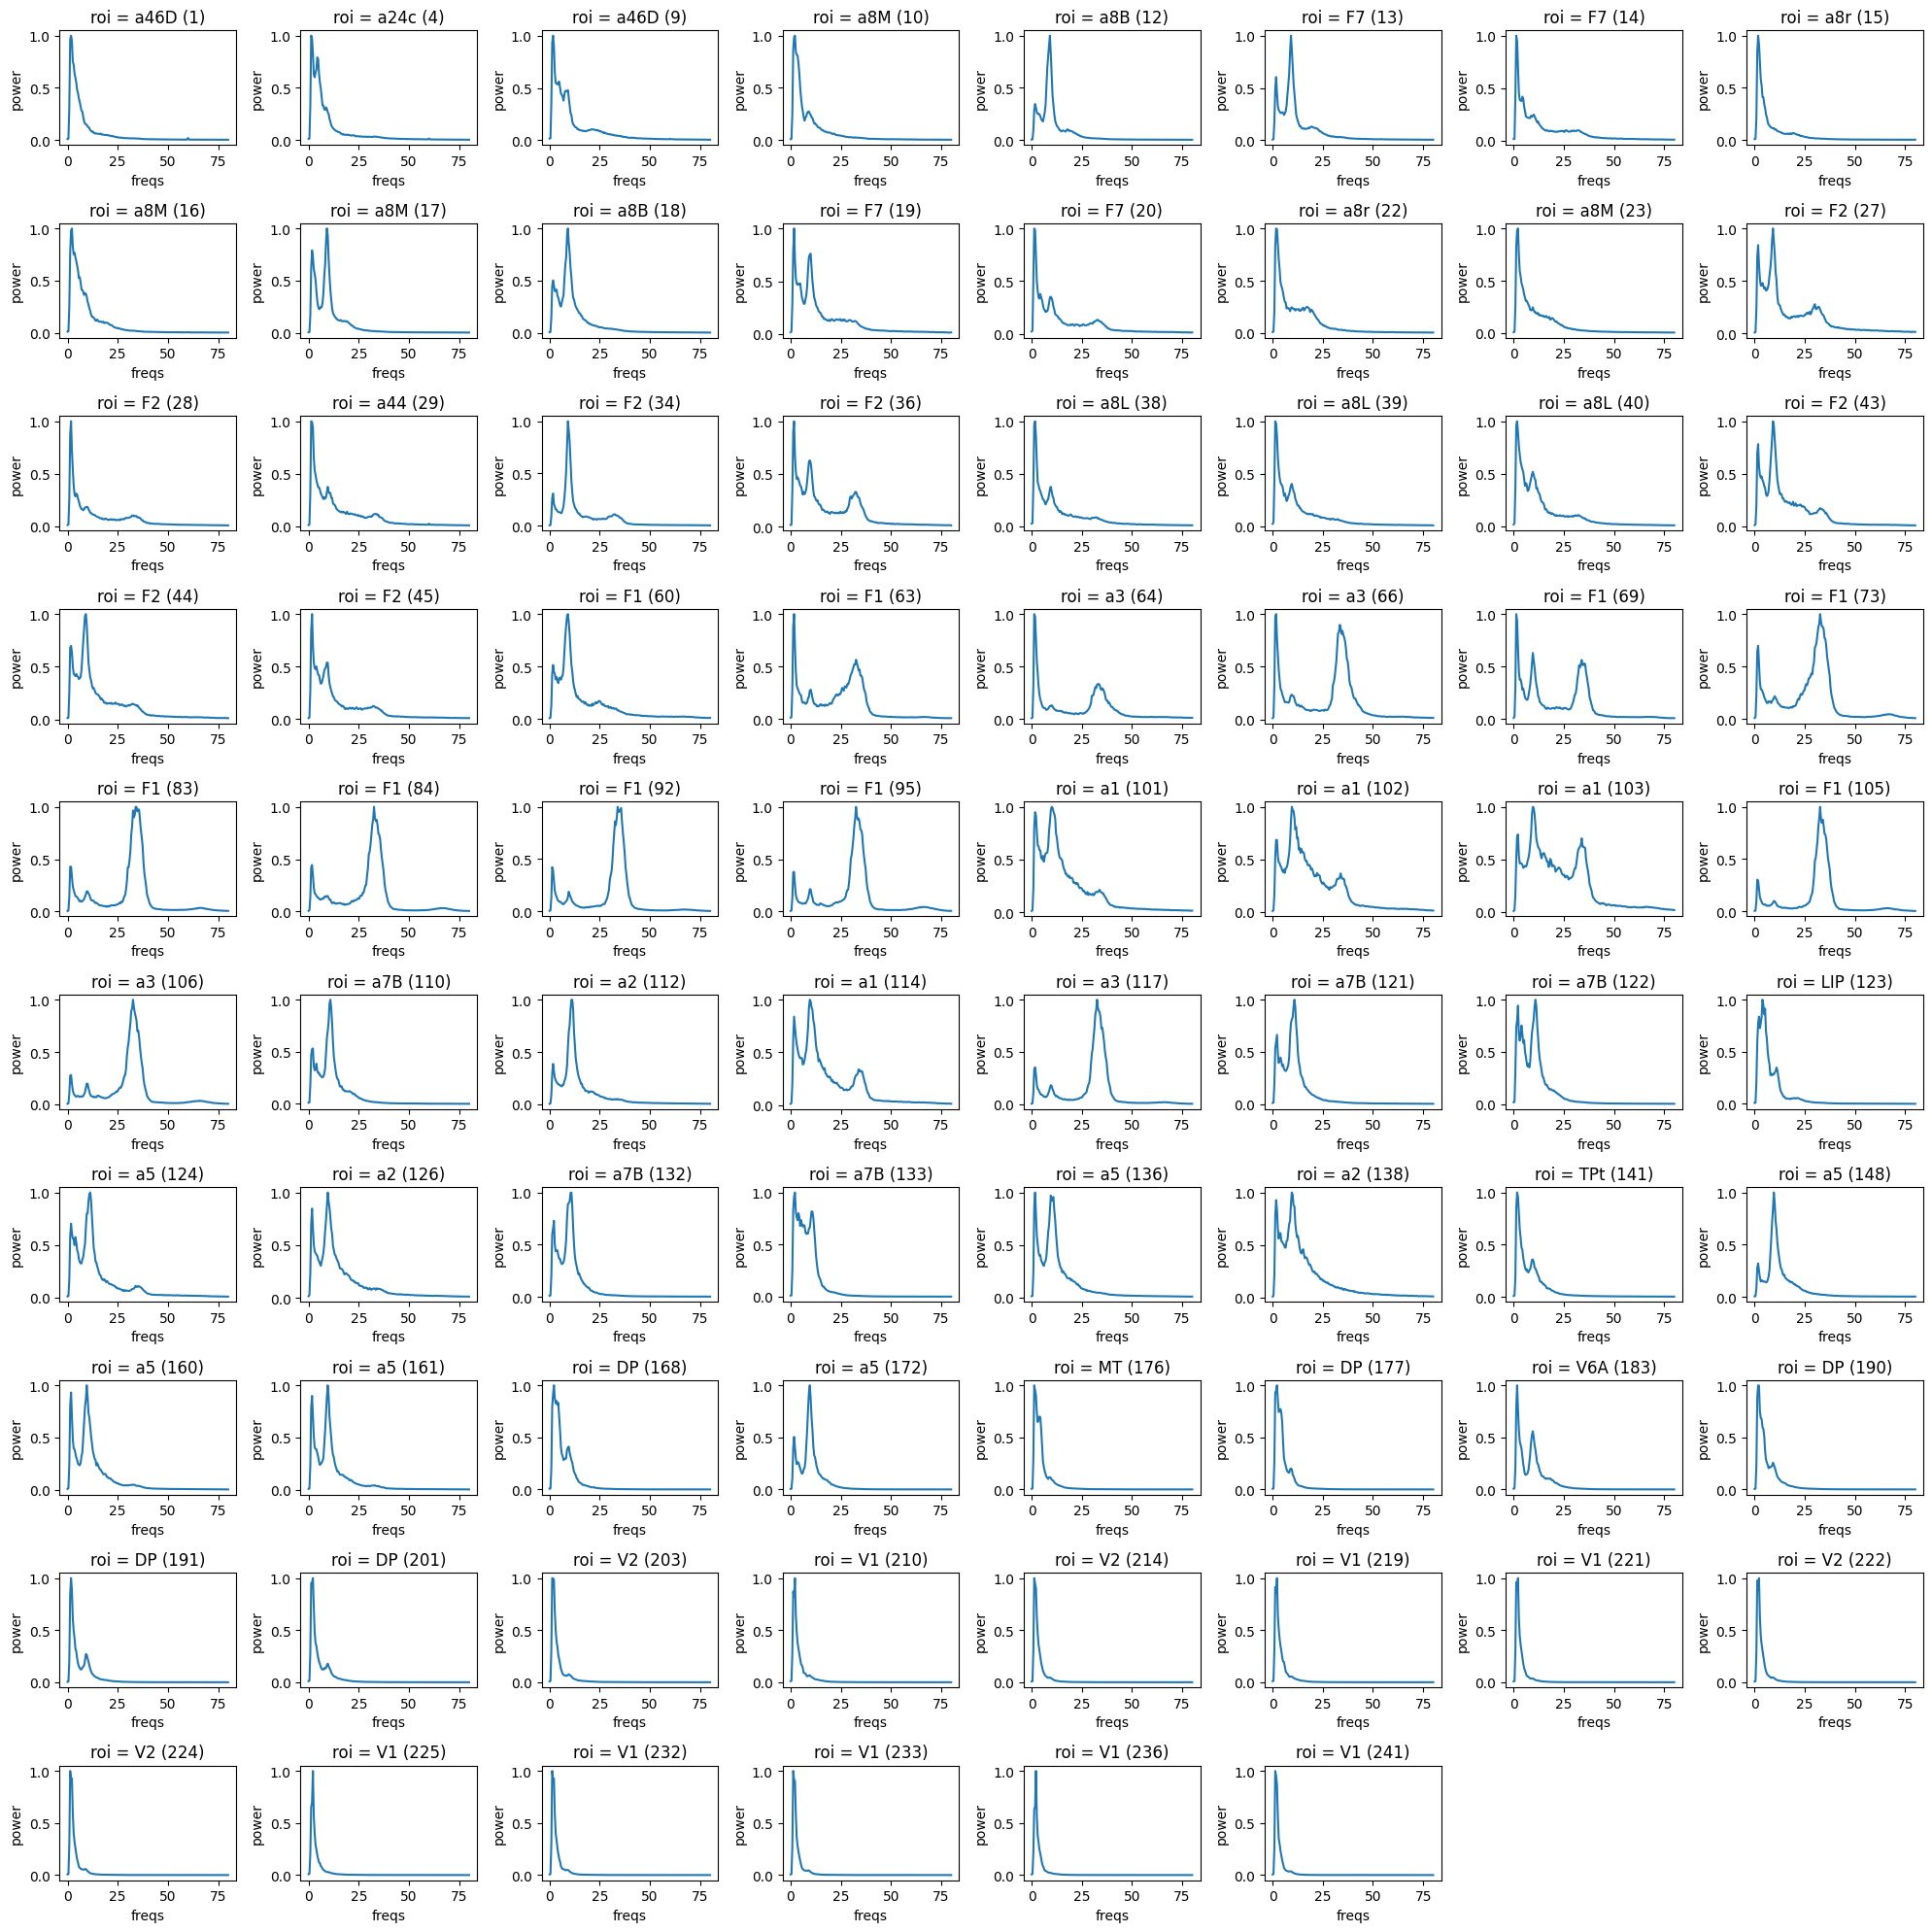

In [65]:
plt.figure(figsize=(20, 20))
for i in range(power_static.sizes['roi']):
    plt.subplot(10, 8, i + 1)
    power_static.isel(roi=i).plot(x="freqs")
plt.tight_layout()
plt.savefig("img/n3.1.2/static_spectra.png", dpi=120)

#### Distribution of peak promininces

In [66]:
def detect_peak_frequencies(power=None, prominence=0.01, verbose=False):

    assert power.ndim == 2
    assert isinstance(power, xr.DataArray)

    roi, freqs = power.roi.data, power.freqs.data
    n_roi, n_freqs = len(roi), len(freqs)

    rois = []
    peak_freqs = []
    peak_prominences = []

    __iter = range(n_roi)
    for i in tqdm(__iter) if verbose else __iter:
        peak_index, peak_info = find_peaks(power[i, :], prominence=prominence)
        peak_freqs += [freqs[peak_index]]
        peak_prominences += [peak_info["prominences"]]
        rois += [[roi[i]] * len(peak_index)]

    return peak_freqs, peak_prominences, rois

In [67]:
peak_freqs, peak_prominences, rois = detect_peak_frequencies(power_static, verbose=True)

100%|██████████████████████████████████████████████████████| 78/78 [00:00<00:00, 2444.71it/s]


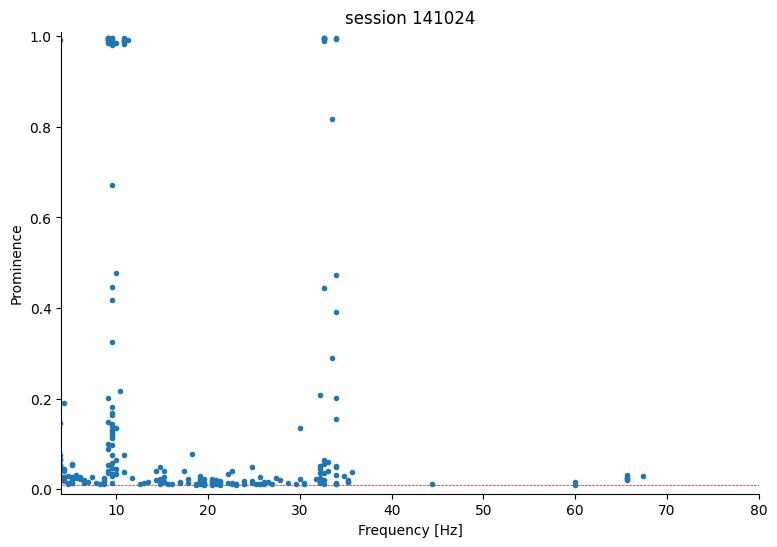

In [68]:
plt.figure(figsize=(9, 6))
ax = plt.subplot(111)
plt.plot(np.hstack(peak_freqs), np.hstack(peak_prominences), ".")
plt.hlines(0.01, 0, 80, "r", ls="--", lw=0.5)
plt.ylim([-0.01, 1.01])
plt.xlim([4, 80.01])
plt.ylabel("Prominence")
plt.xlabel("Frequency [Hz]")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title(f"session {sid}")
plt.savefig("img/n3.1.2/prominence.png", dpi=120)

In [69]:
has_peak = np.zeros((power_static.sizes["roi"], len(bands)), dtype=bool)

In [70]:
for i in tqdm(range(power_static.sizes["roi"])):
    for peak in peak_freqs[i]:
        for n_band, band in enumerate(bands.keys()):
            if not has_peak[i, n_band]:
                has_peak[i, n_band] = bands[band][0] <= peak <= bands[band][1]

100%|█████████████████████████████████████████████████████| 78/78 [00:00<00:00, 59342.59it/s]


In [71]:
has_peak = xr.DataArray(
    has_peak, dims=("roi", "bands"), coords=(data.roi, list(bands.keys()))
)

In [72]:
peak_freqs = xr.DataArray(
    np.hstack(peak_freqs), dims="roi", coords={"roi": np.hstack(rois)}, name="peak_freq"
)
peak_prominences = xr.DataArray(
    np.hstack(peak_prominences),
    dims="roi",
    coords={"roi": np.hstack(rois)},
    name="peak_prom",
)

#### Time-frequency multitaper spectra

In [73]:
indexes = np.logical_and(has_peak[:, 3], has_peak[:, 4])

data_sel = data.isel(roi=indexes)

In [74]:
w = _tf_decomp(
    data_sel,
    data.attrs["fsample"],
    fc,
    mode=mode,
    n_cycles=n_cycles,
    mt_bandwidth=None,
    decim=decim,
    kw_cwt={},
    kw_mt={},
    n_jobs=20,
)

w = xr.DataArray(
    w,
    name="power",
    dims=("trials", "roi", "freqs", "times"),
    coords=(data.trials.values, data_sel.roi.values, fc, data.time.values[::decim]),
)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:    5.4s remaining:    9.0s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:    5.8s remaining:    3.5s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:    6.6s finished


In [75]:
power = (w * np.conj(w)).real

In [76]:
zpower = (power - power.mean("times")) / power.std("times")

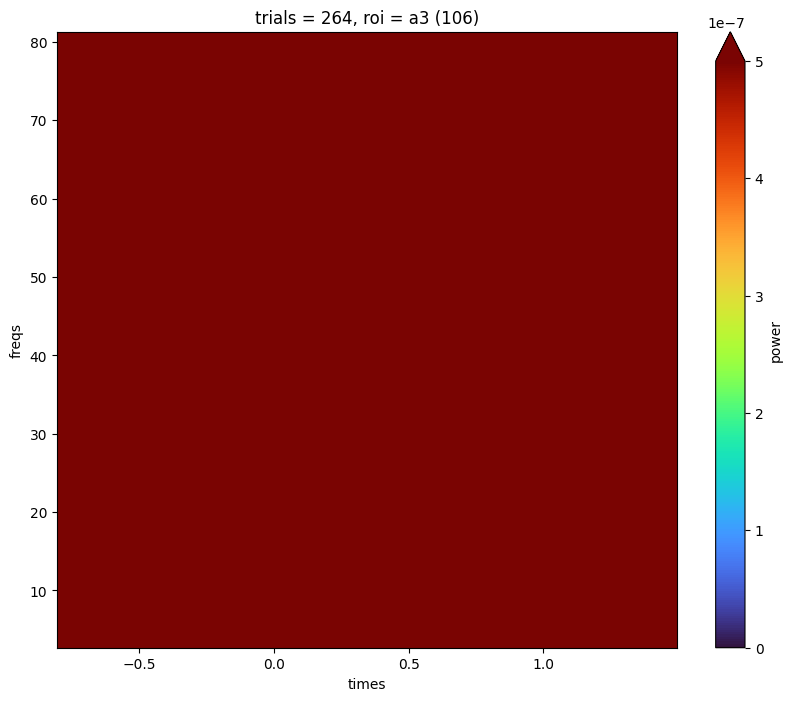

In [77]:
plt.figure(figsize=(10, 8))
power.sel(roi="a3 (106)", trials=264).plot.imshow(
    x="times", y="freqs", vmin=0, vmax=5e-7, cmap="turbo", interpolation="gaussian"
)
plt.savefig("img/n3.1.2/TF_106_264.eps")

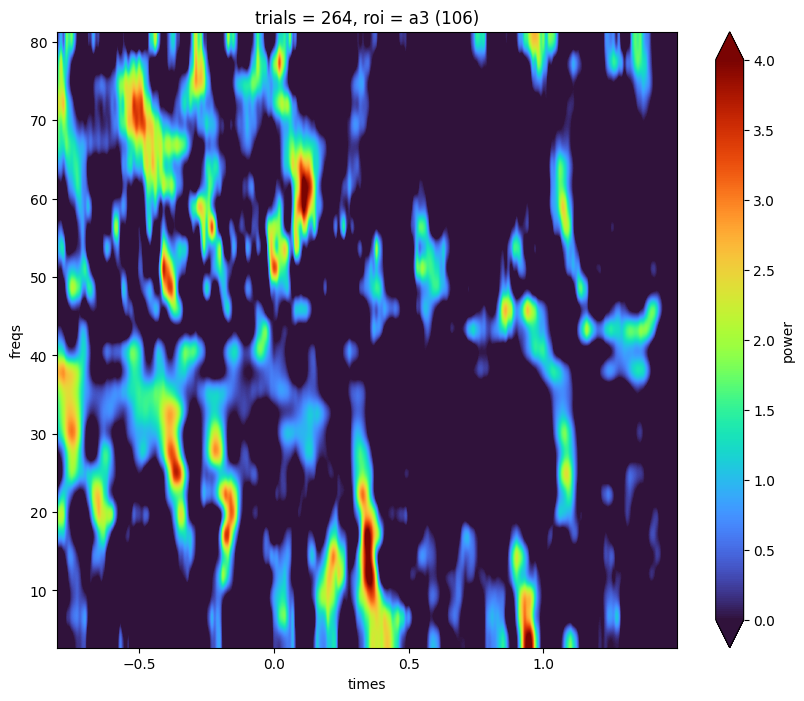

In [78]:
plt.figure(figsize=(10, 8))
zpower.sel(roi="a3 (106)", trials=264).plot.imshow(
    x="times", y="freqs", vmin=0, vmax=4, cmap="turbo", interpolation="gaussian"
)
plt.savefig("img/n3.1.2/TF_106_264_zscore.eps")

In [79]:
alpha = slice(6, 14)
beta = slice(28, 38)
gamma = slice(60, 70)

# Power
power = (w * np.conj(w)).real

power_alpha = power.sel(freqs=alpha).mean("freqs")
power_beta = power.sel(freqs=beta).mean("freqs")
power_gamma = power.sel(freqs=gamma).mean("freqs")

In [80]:
# Phase beta and gamma
phi = np.angle(scipy.signal.hilbert(power_beta)) - np.angle(
    scipy.signal.hilbert(power_gamma)
)
phi = xr.DataArray(phi, dims=power_beta.dims, coords=power_beta.coords)

# Phase beta and gamma
phi_surr = np.angle(scipy.signal.hilbert(power_alpha)) - np.angle(
    scipy.signal.hilbert(power_gamma)
)
phi_surr = xr.DataArray(phi_surr, dims=power_beta.dims, coords=power_alpha.coords)

In [113]:
z_alpha = (power_alpha - power_alpha.mean("times")) / power_alpha.std("times")
z_beta = (power_beta - power_beta.mean("times")) / power_beta.std("times")
z_gamma = (power_gamma - power_gamma.mean("times")) / power_gamma.std("times")
max_beta = power_beta / power_beta.max(("times", "trials"))
max_gamma = power_gamma / power_gamma.max(("times", "trials"))

cc = (z_beta * z_gamma).mean("times")

#CC = (z_alpha * z_gamma).mean("times")  # []
CC = []
for i in tqdm(range(100)):
    x1 = trial_swap_surrogates(z_beta.copy(), seed=i + 1000)
    x2 = trial_swap_surrogates(z_gamma.copy(), seed=i + 2000)

    cc_surr = (x1 * x2).mean("times")

    CC += [cc_surr]

CC = xr.DataArray(
    np.vstack(CC),
    dims=("trials", "roi"),
    coords={"roi": z_gamma.roi},
)

100%|██████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.24it/s]


In [114]:
from scipy.stats import ks_2samp

In [115]:
p_values = []

for i in tqdm(range(cc.sizes["roi"])):
    
    p_values += [ks_2samp(cc.isel(roi=i), CC.isel(roi=i), alternative="two-sided", method="exact")[1]]
    
p_values = xr.DataArray(p_values, dims=("roi"), coords={"roi": cc.roi})

100%|██████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.33it/s]


In [116]:
p_values

<xarray.DataArray (roi: 8)>
array([5.29844087e-003, 4.74790409e-191, 1.15500409e-073, 1.92476261e-243,
       1.03951412e-320, 3.54132969e-074, 2.95888402e-242, 8.86353769e-321])
Coordinates:
  * roi      (roi) <U9 'a44 (29)' 'F1 (73)' 'F1 (83)' ... 'F1 (105)' 'a3 (106)'

In [106]:
ks_2samp?

Signature: ks_2samp(data1, data2, alternative='two-sided', method='auto')
Docstring:
Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.

This test compares the underlying continuous distributions F(x) and G(x)
of two independent samples.  See Notes for a description
of the available null and alternative hypotheses.

Parameters
----------
data1, data2 : array_like, 1-Dimensional
    Two arrays of sample observations assumed to be drawn from a continuous
    distribution, sample sizes can be different.
alternative : {'two-sided', 'less', 'greater'}, optional
    Defines the null and alternative hypotheses. Default is 'two-sided'.
    Please see explanations in the Notes below.
method : {'auto', 'exact', 'asymp'}, optional
    Defines the method used for calculating the p-value.
    The following options are available (default is 'auto'):

      * 'auto' : use 'exact' for small size arrays, 'asymp' for large
      * 'exact' : use exact distribution of test statistic
    

In [92]:
CC

<xarray.DataArray (trials: 582, roi: 8)>
array([[ 0.12305571, -0.13041411,  0.2419382 , ..., -0.19318961,
         0.00244372, -0.07149802],
       [ 0.29842307,  0.01846117,  0.24292097, ...,  0.0965307 ,
         0.12441827,  0.06879793],
       [ 0.22372849,  0.36051195,  0.50376372, ...,  0.19383431,
        -0.11263539,  0.15601647],
       ...,
       [ 0.10051657,  0.01501982,  0.14011694, ...,  0.2178229 ,
         0.26226232, -0.12825791],
       [ 0.20387617,  0.18162584, -0.03635353, ...,  0.12254237,
         0.15436295, -0.08265766],
       [ 0.30627447,  0.23041186,  0.14992387, ..., -0.00681169,
         0.18027618,  0.15174324]])
Coordinates:
  * roi      (roi) <U9 'F1 (95)' 'F1 (105)' 'a3 (106)' ... 'a1 (103)' 'a44 (29)'
Dimensions without coordinates: trials

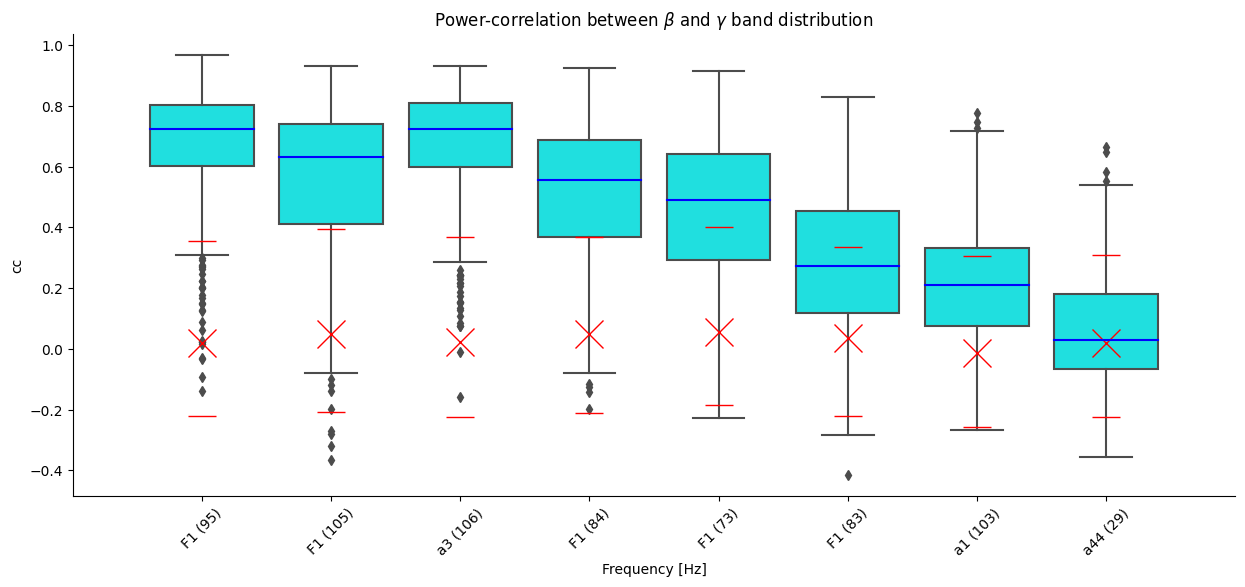

In [83]:
plt.figure(figsize=(15, 6))

df = cc.to_dataframe(name="cc").reset_index()
df = df.sort_values("cc", ascending=False)

ax = sns.boxplot(
    x=df["roi"],
    y=df["cc"],
    color="cyan",
    medianprops=dict(color="b", label="median"),
)

rois = [t.get_text() for t in ax.get_xticklabels()]

CC = CC.sel(roi=rois)

mean = CC.median("trials")
std1 = CC.quantile(0.05, "trials")
std2 = CC.quantile(0.95, "trials")

plt.plot(range(cc.sizes["roi"]), mean, "xr", ms=20)
plt.plot(range(cc.sizes["roi"]), std1, "_r", ms=20)
plt.plot(range(cc.sizes["roi"]), std2, "_r", ms=20)


plt.xticks(rotation=45)
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xlim(-1, cc.sizes["roi"])
plt.title(r"Power-correlation between $\beta$ and $\gamma$ band distribution")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlabel("Frequency [Hz]")
plt.savefig("img/n3.1.2/prominence.png", dpi=120)

In [84]:
def plot_trial_subsamp(roi):

    plt.figure(figsize=(20, 14))

    t_idx = np.random.randint(0, cc.sizes["trials"], 20)

    for i, t in enumerate(t_idx):
        ax = plt.subplot(4, 5, i + 1)
        max_beta.sel(roi=roi).isel(trials=t).plot(color="b")
        max_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
        cc_inst = (z_beta * z_gamma).sel(roi=roi).isel(trials=t)
        (cc_inst / cc_inst.max()).plot(color="green")
        plt.legend([r"$\beta$", r"$\gamma$", "cc(t)"], frameon=False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}, trial = {t}")
    plt.tight_layout()

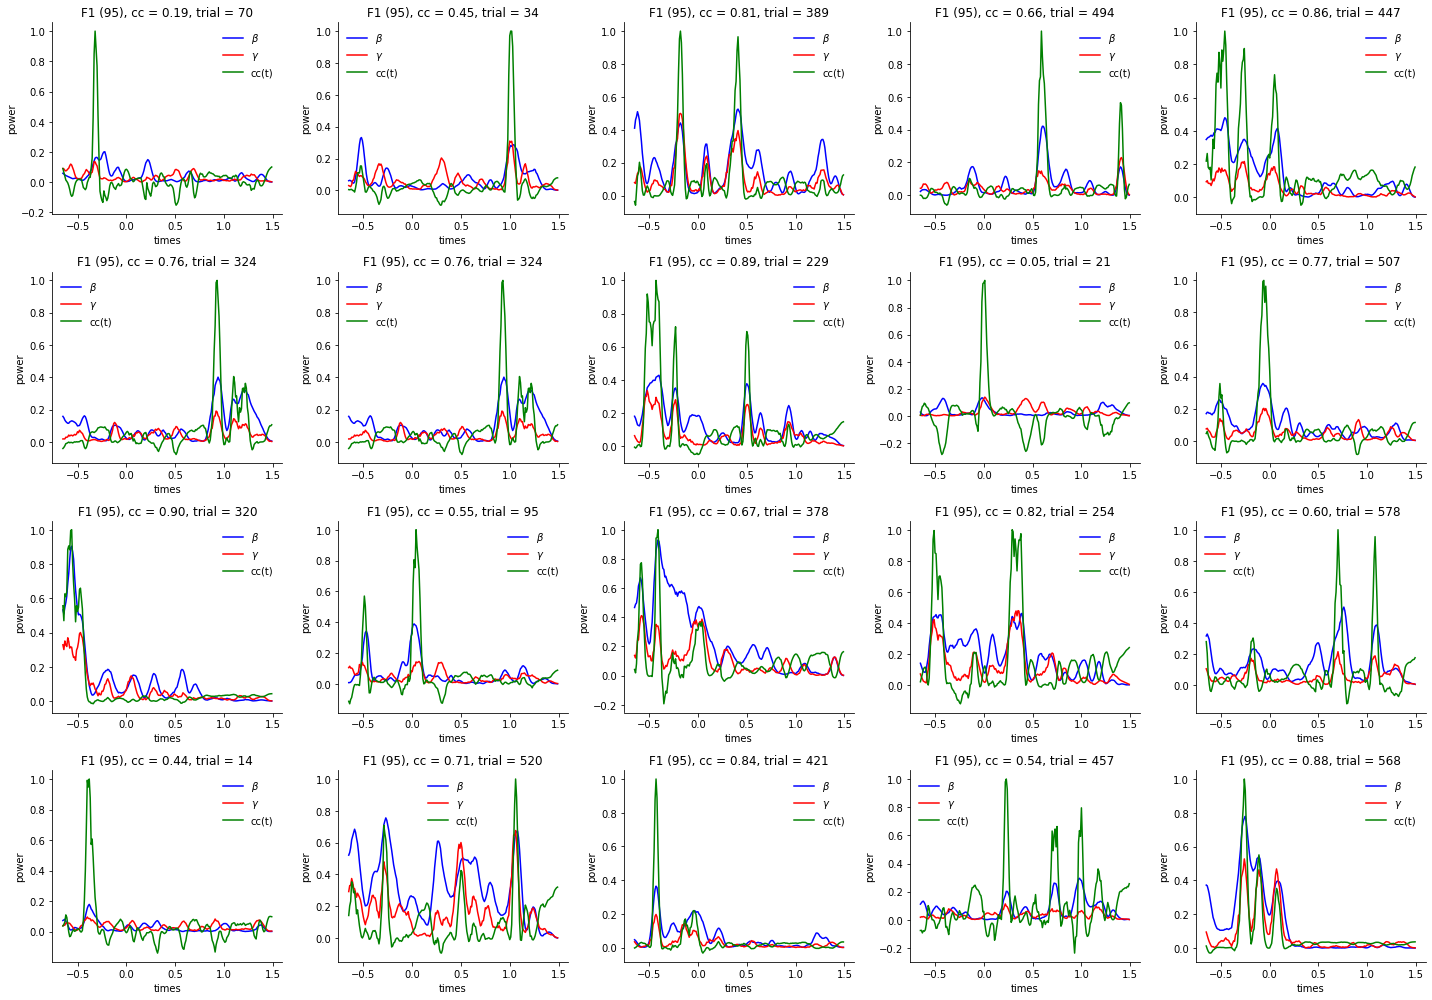

In [85]:
plot_trial_subsamp("F1 (95)")
plt.savefig("img/n3.1.2/time-series.png", dpi=120)

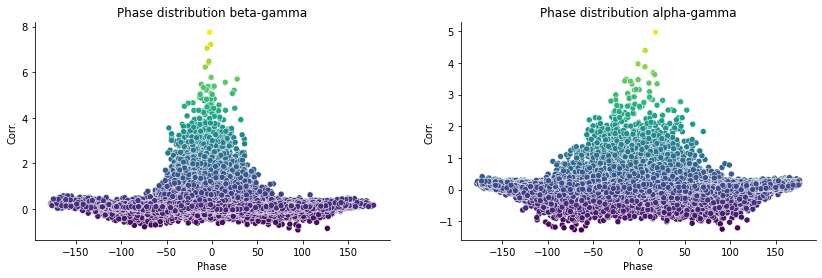

In [86]:
plt.figure(figsize=(14, 4))
ax = plt.subplot(121)
x = (z_beta * z_gamma).sel(roi="F1 (95)").data.flatten()
y = phi.sel(roi="F1 (95)").data.flatten()
sns.scatterplot(data=None, x=y * 180 / np.pi, y=x / 5, c=x)
plt.ylabel("Corr.")
plt.xlabel("Phase")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title("Phase distribution beta-gamma")

ax = plt.subplot(122)
x = (z_alpha * z_gamma).sel(roi="F1 (95)").data.flatten()
y = phi_surr.sel(roi="F1 (95)").data.flatten()
sns.scatterplot(data=None, x=y * 180 / np.pi, y=x / 5, c=x)
plt.ylabel("Corr.")
plt.xlabel("Phase")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title("Phase distribution alpha-gamma")
plt.savefig("img/n3.1.2/phases.png", dpi=120)

#### Phase between beta and gamma LFP

In [49]:
from mne.filter import filter_data

In [89]:
data_beta = filter_data(data_sel, data.fsample, 15, 50)

Setting up band-pass filter from 15 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 881 samples (0.881 sec)



In [90]:
data_gamma = filter_data(data_sel, data.fsample, 50, 80)

Setting up band-pass filter from 50 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 50.00
- Lower transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 43.75 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.265 sec)



In [91]:
data_hp = filter_data(data_sel, data.fsample, l_freq=15, h_freq=140)

Setting up band-pass filter from 15 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 881 samples (0.881 sec)



In [92]:
data_beta = xr.DataArray(data_beta, dims=data_sel.dims, coords=data_sel.coords)
data_gamma = xr.DataArray(data_gamma, dims=data_sel.dims, coords=data_sel.coords)
data_hp = xr.DataArray(data_hp, dims=data_sel.dims, coords=data_sel.coords)

In [105]:
idx, _ = find_peaks(-data_hp.sel(roi="a3 (106)", trials=264), height=0)

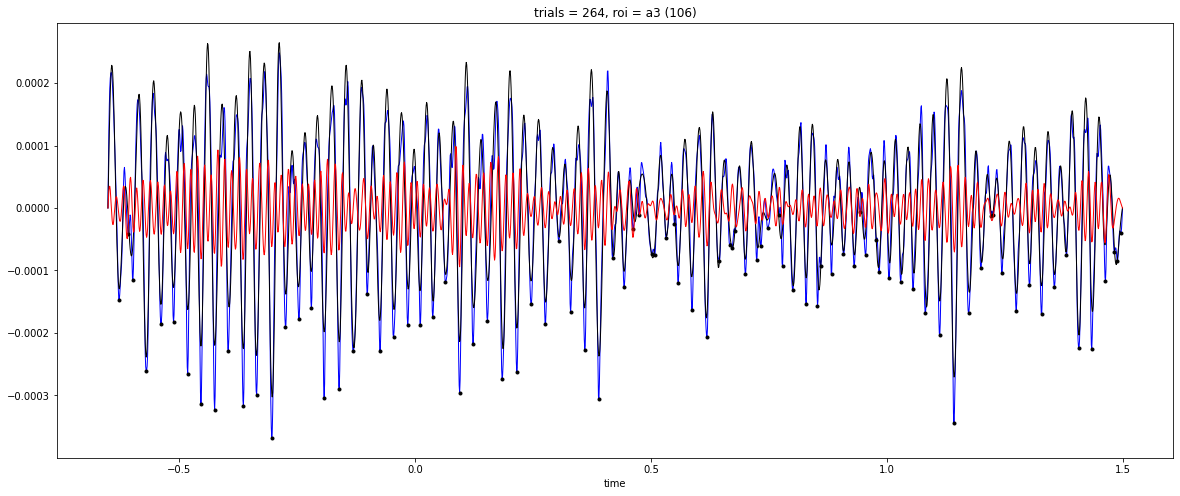

In [108]:
plt.figure(figsize=(20, 8))
data_hp.sel(roi="a3 (106)", trials=264).plot(
    x="time", hue="trials", color="b", lw=1
)
plt.plot(data_hp.time.data[idx], data_hp.sel(roi="a3 (106)", trials=264).data[idx], "k.")
data_beta.sel(roi="a3 (106)", trials=264).plot(
    x="time", hue="trials", color="k", lw=1
)
data_gamma.sel(roi="a3 (106)", trials=264).plot(
    x="time", hue="trials", color="r", lw=1
);

plt.savefig("img/n3.1.2/filtered_traces.eps")

In [34]:
def triggered_avg(
    data=None,
    low_pass=None,
    high_pass=None,
    win_size=None,
    height=None,
    find_troughs=None,
    verbose=False,
):

    n_trials, n_roi, n_times = data.shape
    roi = data.roi.data

    # High-pass filtered data
    data_hp = filter_data(
        data, data.fsample, l_freq=low_pass, h_freq=high_pass, verbose=verbose
    )

    data_hp = (data_hp - data_hp.mean()) / data_hp.std()

    # Converts back to DataArray
    data_hp = xr.DataArray(data_hp, dims=data.dims, coords=data.coords)

    win_size = int(win_size * data.fsample)

    data_hp = data_hp.data.swapaxes(0, 1).reshape(n_roi, n_trials * n_times)

    def _for_roi(i):
        if find_troughs:
            peaks, _ = find_peaks(-data_hp[i], height)
        else:
            peaks, _ = find_peaks(data_hp[i], height)
        snipets = np.zeros((len(peaks), 2 * win_size))
        for pidx, idx in enumerate(peaks):
            temp = data_hp[i, (idx - win_size) : (idx + win_size)]
            if len(temp) == 2 * win_size:
                snipets[pidx, :] = temp

        return snipets.mean(0)

    snipets = np.stack([_for_roi(i) for i in range(n_roi)])

    times = np.linspace(-win_size, win_size, snipets.shape[1])
    snipets = xr.DataArray(snipets, dims=("roi", "times"), coords=(roi, times))

    return snipets


def cycle_triggered_avg(
    data=None,
    band_b=None,
    band_g=None,
    win_size=None,
    height=None,
    find_troughs=None,
    verbose=False,
):

    n_trials, n_roi, n_times = data.shape
    roi = data.roi.data

    # Beta component
    data_beta = filter_data(data, data.fsample, band_b[0], band_b[1], verbose=verbose)
    # Gamma co,ponent
    data_gamma = filter_data(data, data.fsample, band_g[0], band_g[1], verbose=verbose)

    # Converts back to DataArray
    data_beta = xr.DataArray(data_beta, dims=data.dims, coords=data.coords)
    data_gamma = xr.DataArray(data_gamma, dims=data.dims, coords=data.coords)

    data_beta = (data_beta - data_beta.mean()) / data_beta.std()
    data_gamma = (data_gamma - data_gamma.mean()) / data_gamma.std()

    win_size = int(win_size * data.fsample)

    data_beta = data_beta.data.swapaxes(0, 1).reshape(n_roi, n_trials * n_times)
    data_gamma = data_gamma.data.swapaxes(0, 1).reshape(n_roi, n_trials * n_times)

    def _for_roi(i):
        if find_troughs:
            peaks, _ = find_peaks(-data_beta[i], height)
        else:
            peaks, _ = find_peaks(data_beta[i], height)
        snipets = np.zeros((len(peaks), 2 * win_size))
        for pidx, idx in enumerate(peaks):
            temp = data_gamma[i, (idx - win_size) : (idx + win_size)]
            if len(temp) == 2 * win_size:
                snipets[pidx, :] = temp

        return snipets.mean(0)

    snipets = np.stack([_for_roi(i) for i in range(n_roi)])
    times = np.linspace(-win_size, win_size, snipets.shape[1])
    snipets = xr.DataArray(snipets, dims=("roi", "times"), coords=(roi, times))

    return snipets

In [35]:
snipets = triggered_avg(
    data=data_sel,
    low_pass=15,
    high_pass=140,
    win_size=0.05,
    height=3,
    find_troughs=True,
    verbose=True,
)

Setting up band-pass filter from 15 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 881 samples (0.881 sec)



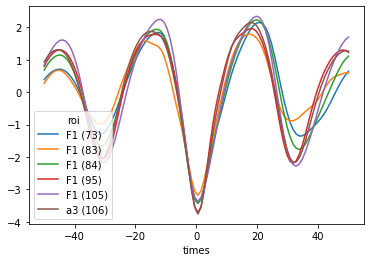

In [36]:
snipets.plot(x="times", hue="roi")

/tmp/ipykernel_914350/963549187.py:39: RuntimeWarning: Mean of empty slice.
  return snipets.mean(0)
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_914350/963549187.py:39: RuntimeWarning: Mean of empty slice.
  return snipets.mean(0)
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_914350/963549187.py:39: RuntimeWarning: Mean of empty slice.
  return snipets.mean(0)
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


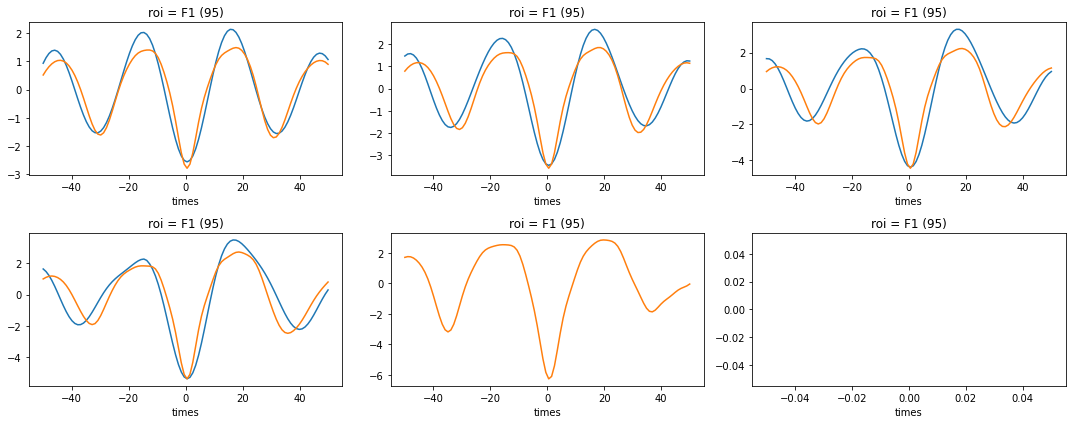

In [37]:
plt.figure(figsize=(15, 6))
for i, a in enumerate([2, 3, 4, 5, 6, 7]):
    plt.subplot(2, 3, i + 1)
    for hp in [50, 140]:
        snipets = triggered_avg(
            data=data.sel(roi=["F1 (95)"]).copy(),
            low_pass=15,
            high_pass=hp,
            win_size=0.05,
            height=a,
            find_troughs=True,
            verbose=False,
        )

        snipets.plot(x="times")
plt.tight_layout()

/tmp/ipykernel_914350/963549187.py:39: RuntimeWarning: Mean of empty slice.
  return snipets.mean(0)
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_914350/963549187.py:39: RuntimeWarning: Mean of empty slice.
  return snipets.mean(0)
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


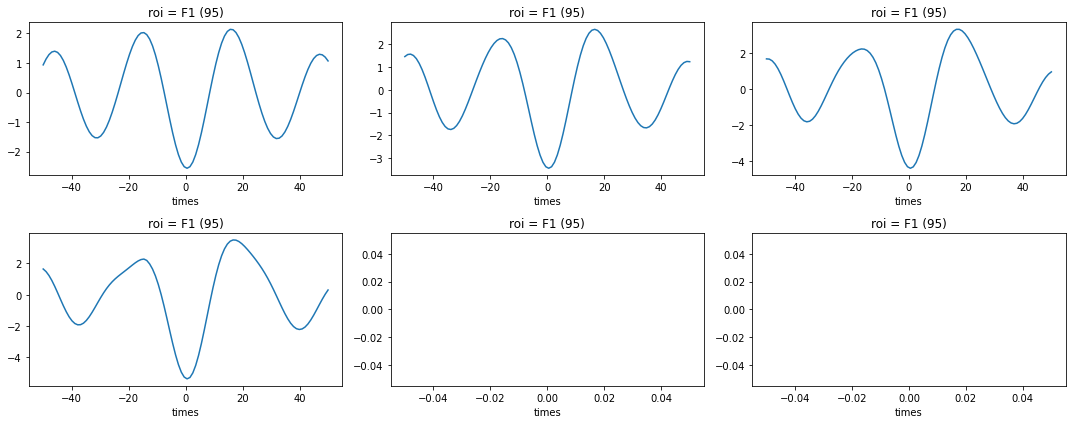

In [38]:
plt.figure(figsize=(15, 6))
for i, a in enumerate([2, 3, 4, 5, 6, 7]):
    plt.subplot(2, 3, i + 1)
    snipets = triggered_avg(
        data=data.sel(roi=["F1 (95)"]),
        low_pass=15,
        high_pass=50,
        win_size=0.05,
        height=a,
        find_troughs=True,
        verbose=False,
    )
    snipets.plot(x="times")
plt.tight_layout()

In [39]:
snipets50 = triggered_avg(
    data=data_sel,
    low_pass=15,
    high_pass=50,
    win_size=0.05,
    height=3,
    find_troughs=True,
    verbose=False,
)

snipets140 = triggered_avg(
    data=data_sel,
    low_pass=15,
    high_pass=140,
    win_size=0.05,
    height=3,
    find_troughs=True,
    verbose=False,
)

In [40]:
snipets_gamma = cycle_triggered_avg(
    data=data_sel,
    band_b=(15, 140),
    band_g=(55, 75),
    win_size=0.05,
    height=3,
    find_troughs=True,
    verbose=False,
)

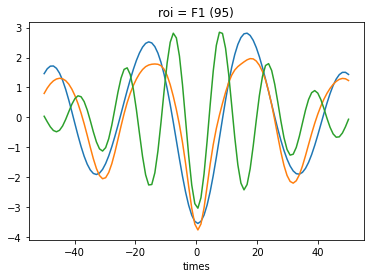

In [41]:
snipets50.sel(roi="F1 (95)").plot(x="times")
snipets140.sel(roi="F1 (95)").plot(x="times")
snipets_gamma.sel(roi="F1 (95)").plot(x="times")

### Ghost Coherence

In [44]:
peaks = power_static.sel(freqs=slice(28, 45))

In [45]:
df = peaks.to_dataframe().reset_index()

<AxesSubplot:xlabel='roi', ylabel='power'>

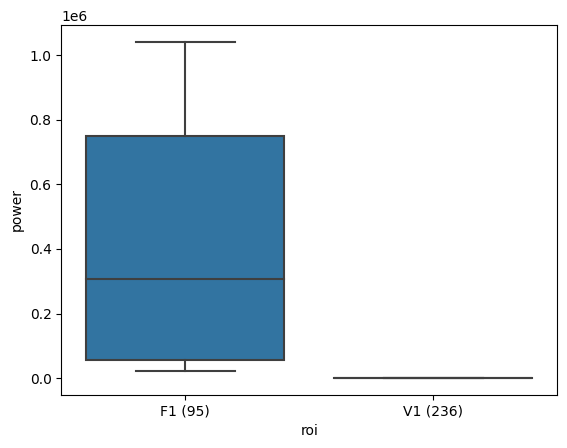

In [47]:
sns.boxplot(data=df.loc[df.roi.isin(["F1 (95)", "V1 (236)"])],
             x="roi", y="power")

In [43]:
trials_5 = peaks.trials[peaks.sel(roi="V1 (236)") < peaks.sel(roi="V1 (236)").quantile(.05)]
trials_95 = peaks.trials[peaks.sel(roi="V1 (236)") > peaks.sel(roi="V1 (236)").quantile(.95)]

AttributeError: 'DataArray' object has no attribute 'trials'

Text(0.5, 1.0, 'V1 (236)')

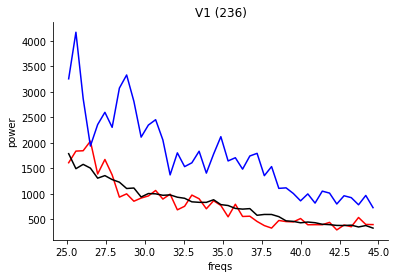

In [46]:
ax = plt.subplot(111)
power_static.sel(roi="V1 (236)", trials=trials_5).sel(freqs=slice(25, 45)).mean("trials").plot(x="freqs", color="r")
power_static.sel(roi="V1 (236)").sel(freqs=slice(25, 45)).median("trials").plot(x="freqs", color="k")
power_static.sel(roi="V1 (236)", trials=trials_95).sel(freqs=slice(25, 45)).mean("trials").plot(x="freqs", color="b")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("V1 (236)")

In [87]:
data_beta = filter_data(data, data.fsample, 28, 42, n_jobs=20)
data_beta = xr.DataArray(data_beta, dims=data.dims, coords=data.coords)

Setting up band-pass filter from 28 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 473 samples (0.473 sec)



[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2668 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 10732 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done 21100 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 33772 tasks      | elapsed:    6.8s
[Parallel(n_jobs=20)]: Done 44966 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 45377 out of 45396 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=20)]: Done 45396 out of 45396 | elapsed:    9.3s finished


In [88]:
data_beta_rms = np.sqrt(np.mean(data_beta**2, -1))

In [89]:
df_rms = data_beta_rms.to_dataframe("rms").reset_index()

<AxesSubplot:xlabel='roi', ylabel='rms'>

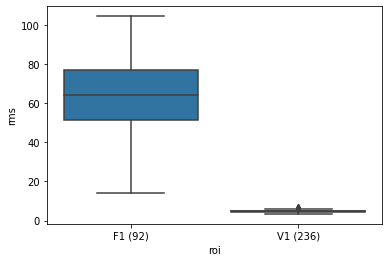

In [90]:
sns.boxplot(data=df_rms.loc[df.roi.isin(["V1 (236)", "F1 (92)"])],
             x="roi", y="rms")

In [91]:
np.where(data_beta_rms.sel(roi="V1 (236)") == data_beta_rms.sel(roi="V1 (236)").max())

(array([460]),)

In [95]:
data_beta_rms.trials[460]

<xarray.DataArray 'trials' ()>
array(736)
Coordinates:
    trials   int64 736

In [96]:
data.sel(roi="F1 (92)", trials=736).plot()
data.sel(roi="V1 (236)", trials=736).plot()

NameError: name 'data' is not defined

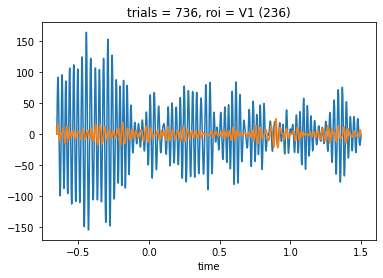

In [98]:
data_beta.sel(roi="F1 (92)", trials=736).plot()
data_beta.sel(roi="V1 (236)", trials=736).plot()